<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [218]:
%%capture
pip install pyswarms

In [219]:
%%capture
pip install scipy

In [220]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps

In [221]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [222]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [223]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [224]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [225]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'pso'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'quarto_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = 'tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [227]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_quarto_cenario/


In [228]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [229]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [230]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [231]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [232]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [233]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [234]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [235]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 400.0000}
    custos = [dist.get(si, CMP) for si in s]
    custo_total = np.sum(custos)
    return custo_total

In [236]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.5: 2000, 1.0: 3000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.20 or si > 1.0 else np.interp(si, [0.5, 1.0], [2000, 3000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [237]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [238]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [239]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [240]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2024-02-01 00:41:23,295 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0822
2024-02-01 00:41:23,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08219823419873916, best pos: [147.53882524   1.00135251   0.47724778]


In [241]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 147.53882524062183
beta: 1.0013525139781585
theta: 0.4772477751611861

Tempo de Convergência para a primeira etapa: 0.0060274600982666016 segundos


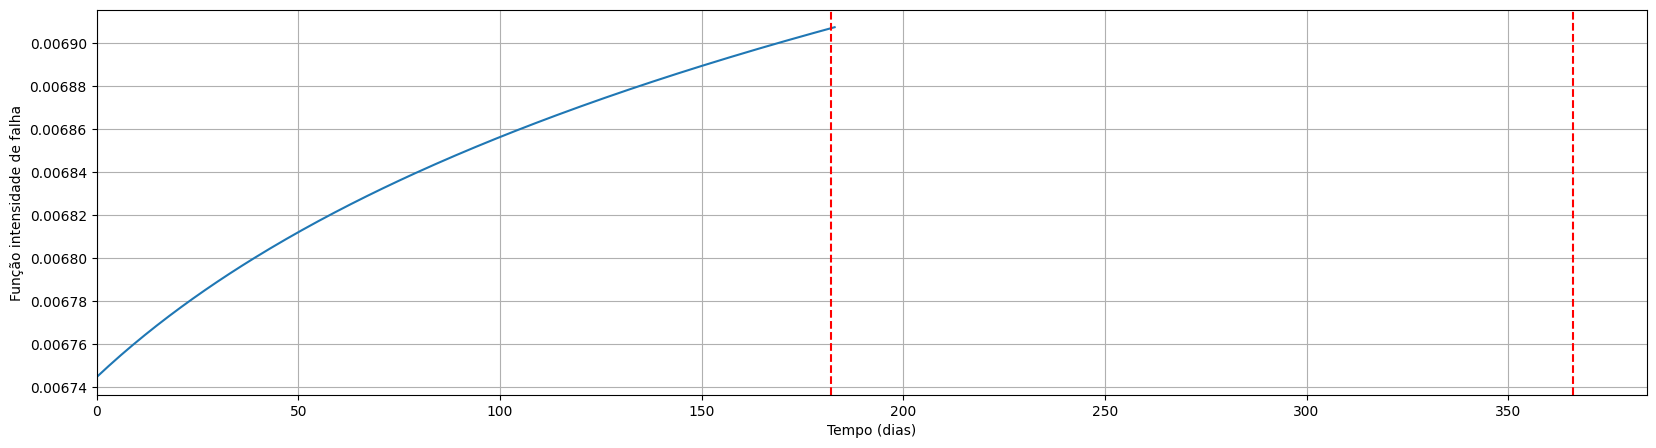

Fator ajuste:  [0.6048420160385737, 0.6048420160385737, 0.6048420160385737, 0.6048420160385737, 0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.6048420160385737, 0.37138407277461827, 0.6048420160385737, 0.37138407277461827, 0.6048420160385737, 0.6048420160385737, 0.6048420160385737]


In [242]:
lamb = 149.00464139548197
beta = 1.0188509450512666
theta = 0.9284696346474378

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [243]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'

In [244]:
# # Gravar os valores de Lambda, Beta e Theta em um arquivo separado
# melhores_parametros = []

# try:
#     with open(nome_arquivo_parametros, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_parametros.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução


# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [245]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,148.378437,1.000280,0.443913,0.014879
1,1,148.378437,1.000280,0.443913,0.014879
2,2,149.934101,1.002761,0.525065,0.008266
3,3,149.166967,1.009657,0.846362,0.007395


In [246]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,1.500000,148.964486,1.003245,0.564813,0.011355
std,1.290994,0.745667,0.004432,0.191558,0.004085
min,0.000000,148.378437,1.000280,0.443913,0.007395
25%,0.750000,148.378437,1.000280,0.443913,0.008048
50%,1.500000,148.772702,1.001521,0.484489,0.011572
75%,2.250000,149.358751,1.004485,0.605389,0.014879
max,3.000000,149.934101,1.009657,0.846362,0.014879


In [247]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

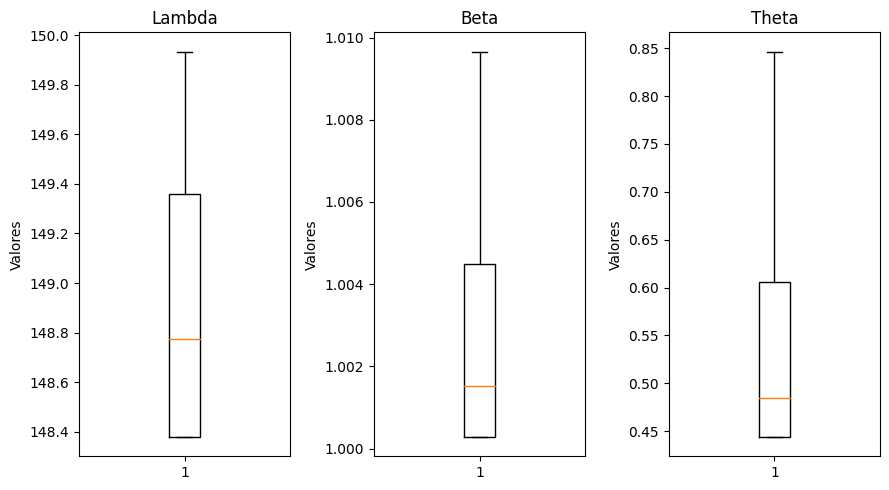

In [248]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [249]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [250]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.5, 3:0, 5:0, 7:1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [251]:
num_particles = 100
max_iterations = 100
dimensions = VALOR_DIMENSOES
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2024-02-01 00:41:25,295 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=342<ipython-input-250-589f9e28a1de>:79: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=342



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 246, 695]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.666632424713889, 4.7760665754336, 5.020468742640598]
Custo =  379.97364217071856


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 126, 180, 511]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8429423008082217, 1.2074490258409738, 3.49479320300035, 5.022207962031725]
Custo =  477.9604408289264


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 361, 424, 457]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.46349657

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=218



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 276, 360, 451, 543, 633]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.873940763730055, 2.4483171057052986, 3.0775848934196732, 3.716097781770334, 4.342617940219044, 5.019713432272965]
Custo =  738.9819792202953


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 422, 484, 513, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.8882541441870218, 3.3144279739008398, 3.5155833373408907, 4.343777439160007, 5.027849047003126]
Custo =  662.0923679984977


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 4, 1

pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=218



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 182, 275, 458, 482, 510, 661]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.2260528832348883, 1.8588962575783525, 3.1233112187373386, 3.289593738525543, 3.4837925427170777, 4.535373502121862, 5.017100551707741]
Custo =  964.3227962324574


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 188, 243, 510, 661]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.2672468120378308, 1.6405432814005239, 3.4874932402060463, 4.539074199610831, 5.02080124919671]
Custo =  612.5875472877536


Número de ciclos de manutenção

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=218
2024-02-01 00:41:26,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.30626151 1.2665187  0.64026632 0.36283808 1.00228962 0.54325394
 0.63165649 0.24764353 0.91699059 1.08199584 1.07644198 1.07751859
 0.494016   0.70526084 0.05468346 0.99355533 1.28238264 0.00572991
 0.45011401 0.54971212 0.37395171 1.00507323 1.15374191 0.79704187]
2024-02-01 00:41:26,011 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 270, 428, 510, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.8324435399333479, 2.916653581937814, 3.4851138102545156, 4.557659559666161, 5.018450125091162]
Custo =  605.6601718974625


Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 511, 661]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 3.5100275654309394, 4.54749790483465, 5.0292249544205285]
Custo =  357.73711775717766


Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 3, 37, 300]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,026 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.36281324 0.81893125 0.59285701 0.3628972  0.66560257 0.54318628
 0.63360592 0.37723887 0.91822148 1.0934002  0.72481486 1.09284101
 0.40222854 0.99954307 0.05469677 0.99362332 0.23484611 0.8712323
 0.72405413 0.54944672 1.02898288 1.00457703 1.15398107 0.8098594 ]
2024-02-01 00:41:26,027 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 451, 660]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 3.090605772822274, 4.53641071203816, 5.025116415047132]
Custo =  353.85571801561525


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.43048935 0.88224308 0.5814765  0.362957   0.70101673 0.54305038
 0.63382325 0.95197689 0.91694831 1.08995666 0.75395542 1.03423554
 0.41846525 0.8283412  0.05468674 0.99338858 0.00255138 0.95021753
 0.82462306 0.54928009 0.04852686 1.00367367 1.15168142 0.80871592]
2024-02-01 00:41:26,047 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 2]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 0.012374795451337517, 5.047200082934607]
Custo =  1199.2977506546044


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.60009159 0.84404021 0.57520289 0.36298831 0.67692974 0.54296016
 0.63383599 0.2372678  0.91581077 1.08497791 0.68676777 0.86086828
 0.44668346 0.65418202 0.05467729 0.99320854 0.93257088 1.19735204
 0.94172889 0.5491704  0.5622848  1.00303285 1.14967555 0.8075832 ]
2024-02-01 00:41:26,065 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 423, 517]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.895227523664285, 3.5422847922612277, 5.027920360417864]
Custo =  345.93808474360196


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.83115286 0.7931176  0.57624432 0.36297273 0.59391662 0.54289021
 0.63382191 1.02407041 0.91500054 1.08046805 0.52765818 0.61037856
 0.4844349  0.50198697 0.05467055 0.99310281 0.41065317 0.18729309
 1.13066306 0.54915989 1.14799443 1.00254178 1.14836122 0.80486918]
2024-02-01 00:41:26,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 5, 123, 300]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.03147600335446867, 0.8211531054118757, 2.032701256963978, 5.025790511731543]
Custo =  834.7941053376717


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.0609349  0.74431295 0.59051192 0.3629432  0.49874062 0.54284617
 0.63374837 0.56893258 0.91464627 1.0764574  0.41195635 0.36638707
 0.5189243  0.3988169  0.05466458 0.99309196 0.98816146 0.66086961
 0.1108994  0.54918773 0.47728921 1.00234054 1.14796586 0.8015599 ]
2024-02-01 00:41:26,092 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 126, 301, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8429423008082217, 2.0359754247325395, 4.741369853953467, 5.020678763298085]
Custo =  494.115194386416


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.18532642 0.66357903 0.6166508  0.36290419 0.34735228 0.542886
 0.63335081 0.22369412 0.91498196 1.0743572  0.3156271  0.1985332
 0.54454604 0.3752558  0.0546593  0.993206   0.14843885 1.20466076
 0.53829927 0.54934267 1.14438242 1.00224636 1.14895028 0.79781854]
2024-02-01 00:41:26,111 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 127, 303, 457, 518, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.849758940799944, 2.0497596336820547, 3.114165752439366, 3.5372519329389838, 4.742915266433819, 5.015242989483956]
Custo =  755.3585477900992


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.09850108 0.54500665 0.64035813 0.36285983 0.18210442 0.54294445
 0.63270962 0.04316444 0.91558562 1.07374117 0.1471263  0.03072586
 0.55546266 0.39212675 0.0546616  0.99333105 0.67336201 0.31292855
 1.04061997 0.54959187 0.52375492 1.00238948 1.15010781 0.7942621 ]
2024-02-01 00:41:26,121 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 128, 243, 271, 304, 331, 661, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8565765926889788, 1.6374200758910038, 1.8292784600476681, 2.055882406821235, 2.2416049571896846, 4.535956603872922, 4.752211834922139, 5.017558290412277]
Custo =  1187.195170843202


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.4245026  0.32936503 0.66168204 0.3628144  1.20669785 0.5430048
 0.63189502 0.06061948 0.91622839 1.07494516 0.06730308 0.05763604
 0.56484441 0.45617074 0.05466851 0.99349931 1.17302692 0.93759523
 0.19127292 0.54984175 1.24696236 1.00283781 1.15155881 0.79177078]




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 126, 218, 247, 305, 334, 630, 663, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8429423008082217, 1.4663167995956785, 1.6646678934872459, 2.0628158144239963, 2.262325043444849, 4.318861092636993, 4.548877890288795, 4.744203264045077, 5.016530987095214]
Custo =  1328.995380737383


2024-02-01 00:41:26,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,160 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.84280442 0.26593516 0.67529067 0.36277809 0.8221413  0.54307657
 0.63111878 0.24678576 0.91698745 1.07691148 0.15980168 1.25867544
 0.57147801 0.55297028 0.0546781  0.99365546 0.19620642 0.44520691
 0.72892486 0.55006632 0.621052   1.00372754 1.15345541 0.79080079]
2024-02-01 00:41:26,161 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 123, 210, 305, 335, 454, 510, 631, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8224985316354543, 1.4115740698437542, 2.063297762333343, 2.2696958365531477, 3.0924330452328928, 3.4807397659754424, 4.322813765299327, 4.566788955742694, 5.013621430612399]
Custo =  1213.7765783099694


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.25905724 0.2000213  0.68367164 0.3627627  0.3525173  0.54318134
 0.63046445 0.54446348 0.91767116 1.07989536 0.21666937 1.00399991
 0.57482915 0.67149979 0.05468758 0.99377612 0.38815016 0.06252988
 1.28950089 0.55024739 0.02890677 1.00467994 1.1551711  0.79057164]
2024-02-01 00:41:26,175 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 120, 305, 336, 631, 667]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.063558164075357, 2.2768456691994916, 4.326528777552957, 4.577480318814118, 5.017333618707588]
Custo =  805.3310973630294


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.32320395 0.22543679 0.68199817 0.36277101 1.23842035 0.54329557
 0.63020251 0.91725278 0.91823909 1.08318776 0.1974914  0.6635054
 0.56996497 0.77841283 0.05469489 0.99387425 0.45279988 1.1397275
 0.42594559 0.55038269 0.8729575  1.00564162 1.156689   0.79224118]
2024-02-01 00:41:26,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 304, 336, 456, 510, 631, 668]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.0678138056498923, 2.2862387940965068, 3.115953903209207, 3.4903989815540135, 4.332472980877898, 4.590401176924877, 5.023275215657806]
Custo =  951.4500191201158


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,211 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.77804521 0.12634078 0.67261153 0.36279224 0.70209919 0.54339303
 0.63016315 1.29770718 0.91839719 1.08614494 0.14946931 0.33375548
 0.54752291 0.85440877 0.05469909 0.99388565 0.57390649 1.00932842
 0.95575263 0.55042075 0.40330916 1.00640378 1.15736499 0.79401594]
2024-02-01 00:41:26,212 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 4, 213, 304, 336, 631, 668]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.02507510293956619, 1.4378322222954456, 2.062118840530382, 2.282283756228177, 4.331966864581641, 4.589895060628621, 5.0227690993615495]
Custo =  1402.1858089628206


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.00234471 0.16792095 0.66013371 0.36282338 0.14451331 0.5434521
 0.63016402 0.28101209 0.91837714 1.08872846 1.28476459 1.20747135
 0.51628989 0.91669916 0.05470178 0.99381268 0.64491685 0.90429222
 0.17290322 0.55031418 1.27391241 1.00677469 1.1570188  0.79651471]
2024-02-01 00:41:26,227 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 186, 302, 334, 420, 452, 631, 668]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.2535127088910778, 2.044316324423759, 2.264455919761294, 2.8583419922332327, 3.0797643022568026, 4.324886311336491, 4.58281450738347, 5.015688546116399]
Custo =  1101.2838384504012


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.6260862  0.17499923 0.64732184 0.36285497 1.06066456 0.54347639
 0.63027441 0.66492538 0.91834232 1.09085823 1.00023009 0.65548378
 0.48612785 0.92012854 0.05470416 0.99372801 0.74148564 0.84639156
 0.82159424 0.55009902 0.86009322 1.00704881 1.15653091 0.79885419]
2024-02-01 00:41:26,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 243, 301, 333, 421, 630, 667]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6459268874483701, 2.041137898465497, 2.261264776437773, 2.8689765360163264, 4.322340793179127, 4.580261616792985, 5.020114916686455]
Custo =  947.4897347230017


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,254 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.01595431 0.31585805 0.6339567  0.3628802  0.57333218 0.54345658
 0.63057926 1.10048951 0.91800507 1.09097664 0.61577392 0.12704912
 0.45949563 0.91308814 0.05470216 0.99361431 0.81117681 0.69176399
 0.17276637 0.54979312 0.4656117  1.00684319 1.15604718 0.80055911]
2024-02-01 00:41:26,255 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 4, 218, 300, 331, 424, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.02507510293956619, 1.4722520792136442, 2.034735852633511, 2.247961802305467, 2.8902554371031552, 4.5745457293982295, 5.0213782042679345]
Custo =  1373.528768289437


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.79622607 0.41391235 0.62197865 0.36290111 0.10509954 0.54341256
 0.63095235 0.07395081 0.91751649 1.08967323 0.20422608 1.01024615
 0.44049933 0.85166937 0.05469725 0.99349481 0.7548584  0.64406345
 0.95164639 0.54951621 0.10360342 1.00647849 1.15555846 0.80175743]
2024-02-01 00:41:26,275 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 270, 300, 425, 514, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.8324435399333479, 2.036783833148613, 2.899778989956644, 3.5168211291281635, 4.5685290534244025, 5.0223406168750975]
Custo =  777.288141057752


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.19547427 0.50746945 0.61607932 0.36291034 0.98201965 0.54332966
 0.63134029 0.46215021 0.91698673 1.08713788 1.08399442 0.50757398
 0.42965636 0.7756078  0.05469099 0.99340123 0.62683194 0.61024324
 0.37071899 0.54931564 1.09335991 1.00592797 1.15506541 0.80275809]
2024-02-01 00:41:26,291 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 300, 423, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.040096284136308, 2.8838259939909756, 4.56106550138775, 5.021856066812751]
Custo =  475.54492498636995


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.97341502 0.67910069 0.61119357 0.36289903 0.4758632  0.54325242
 0.63175413 0.92238456 0.91651031 1.08467819 0.57523311 1.26966598
 0.43282084 0.68811143 0.05468527 0.99333822 0.42849557 0.55724423
 1.14977381 0.54922745 0.73050016 1.00532151 1.15449966 0.80195605]
2024-02-01 00:41:26,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 188, 210, 247, 420, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.2672468120378308, 1.4160949866194135, 1.6691264467590856, 2.8624029962033815, 4.553476835808294, 5.021246316388979]
Custo =  822.9962361021646


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.41452316 0.74538545 0.61412715 0.36288085 1.27676152 0.54318331
 0.63211825 1.28840415 0.91618144 1.08214115 0.00350455 0.63844326
 0.43881878 0.61194909 0.05467983 0.99329525 0.21791333 0.62979582
 0.50464631 0.54919519 0.33510748 1.00472903 1.15376693 0.80104731]
2024-02-01 00:41:26,323 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 120, 181, 300, 662]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.213894072424938, 2.029592720756187, 4.5455856674531585, 5.020333976158453]
Custo =  614.5214720415686


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,336 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.20552085 0.6899823  0.618347   0.36286195 0.62701542 0.54313084
 0.63237416 0.34926917 0.91594962 1.07982076 0.7591638  0.04188953
 0.4580218  0.56419682 0.054675   0.99329671 0.05908349 0.80646892
 1.21158162 0.54926717 1.2892245  1.00423615 1.15310464 0.80020906]
2024-02-01 00:41:26,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 121, 212, 301, 456, 662]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8088745595126113, 1.4251531072549328, 2.0356174373897407, 3.106872615995073, 4.540882994842262, 5.015631303547556]
Custo =  730.559893554435


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.54537198 0.52997095 0.62497212 0.36284136 1.24283977 0.54311474
 0.63251736 0.8030858  0.9159457  1.07811018 0.16517141 0.97887752
 0.47722938 0.52375827 0.05467208 0.99330223 0.02062005 1.05201363
 0.49341799 0.54943375 0.74683402 1.00394624 1.15255944 0.79866006]
2024-02-01 00:41:26,355 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 122, 274, 301, 662]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8156860192879709, 1.8501008266422376, 2.035484597743768, 4.544557238764927, 5.019305547470221]
Custo =  652.9169870905445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.18196281 0.4175256  0.63298389 0.36282218 0.42792146 0.54314078
 0.6326245  0.0229877  0.91623503 1.0767066  1.06413806 0.54981936
 0.49695992 0.49614337 0.05467142 0.99336178 0.09614858 1.23616533
 1.14258757 0.54965786 0.15380456 1.00383589 1.15229934 0.79715532]
2024-02-01 00:41:26,371 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 123, 248, 302, 330, 518, 662]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8224985316354543, 1.671575762101607, 2.0422164562565737, 2.234803941418238, 3.537080076761172, 4.539996270468036, 5.01474457917333]
Custo =  916.0856438667604


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,382 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.53742013 0.26141225 0.64141611 0.36280523 0.88046378 0.54317832
 0.63256257 0.6619229  0.91670025 1.0757003  0.57482148 0.15100758
 0.51406261 0.51635368 0.0546731  0.99344269 0.23903619 1.23743031
 0.47007476 0.54987013 0.96648852 1.00392131 1.15237038 0.79578365]
2024-02-01 00:41:26,383 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 1, 124, 274, 303, 332, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.0061070761237358665, 0.8289265254719081, 1.8542668746183542, 2.0534024723307183, 2.252888667091848, 4.554323922475174, 5.022093403055857]
Custo =  2913.104430191342


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.24560014 0.25496113 0.6489091  0.3627944  0.01681007 0.54321884
 0.632266   0.00453591 0.91715529 1.07621237 0.15344378 1.13755605
 0.52572753 0.55948786 0.05467703 0.99354766 0.27564851 0.04090407
 1.15899164 0.55003492 0.47383523 1.00410049 1.15256234 0.79472563]
2024-02-01 00:41:26,399 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 124, 212, 303, 334, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8293120881580519, 1.425265587932093, 2.0495099905393315, 2.2627729845518876, 4.319309033744032, 4.5563013798952126, 5.017091945320214]
Custo =  942.7228955263523


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,410 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.50184937 0.40711517 0.65434617 0.36278608 0.60810684 0.54326251
 0.63186867 0.74416378 0.91754294 1.07751169 0.94606972 0.71374834
 0.53147287 0.60242916 0.0546807  0.99364354 0.36821686 0.25916517
 0.46629751 0.55012108 0.01173657 1.00435556 1.15306679 0.79414379]
2024-02-01 00:41:26,411 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 8, 123, 272, 303, 335, 488, 514, 630, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.050809792364033136, 0.8206246869158149, 1.8389859707002665, 2.051848947436599, 2.272001221938822, 3.330948020592731, 3.5113052434581857, 4.31858852883636, 4.56255672927787, 5.016368292728565]
Custo =  1628.9160595558612


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.13142455 0.66812028 0.65614314 0.36278613 1.21561482 0.54329941
 0.63150186 0.11873695 0.91787344 1.07997177 0.39027952 0.29484843
 0.53643399 0.65316915 0.0546841  0.99372625 0.582337   0.57086043
 1.14164806 0.55018064 0.9890526  1.00477215 1.15370418 0.79378507]
2024-02-01 00:41:26,429 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 122, 240, 303, 336, 631, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8156860192879709, 1.6167173823226193, 2.0490970322710917, 2.276139171049641, 4.325822279403106, 4.569797469846472, 5.016629944716177]
Custo =  942.6393311455154


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.34677301 0.90261233 0.65575375 0.36279014 0.46185372 0.54333066
 0.63120786 0.86290741 0.91795597 1.0822556  1.18744882 1.25873485
 0.53743682 0.71028172 0.05468704 0.99376828 0.7615638  0.84198583
 0.52083574 0.55017269 0.63245744 1.00518732 1.15428346 0.79388358]
2024-02-01 00:41:26,444 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 271, 303, 336, 631, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.8294593803901993, 2.0491857320414257, 2.276227870819975, 4.32591097917344, 4.569886169616806, 5.016718644486511]
Custo =  970.2134581315938


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.93330155 0.99707021 0.65479215 0.36280754 0.96497492 0.5433527
 0.63100869 0.28010675 0.91795164 1.08429443 0.58066304 0.82506271
 0.53768868 0.76065736 0.05468965 0.99376579 0.82738919 0.99462327
 1.26097972 0.55008515 0.29986791 1.00553339 1.15464494 0.79442947]
2024-02-01 00:41:26,463 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 303, 335, 421, 515, 630, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.0608837771667745, 2.279296741375616, 2.8732108675837007, 3.5249129284121894, 4.325242998707031, 4.576187358533732, 5.023019833403437]
Custo =  943.497028847135


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,475 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.17446898 1.01424613 0.65069112 0.36282342 0.12893989 0.54334749
 0.63095954 1.0547363  0.91775545 1.08552921 1.2388164  0.37519783
 0.52816486 0.80330258 0.05469087 0.99370764 0.84269921 1.05376954
 0.575074   0.54994346 0.02053243 1.00575151 1.15474817 0.79541971]




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 274, 302, 335, 424, 488, 630, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.860106447758736, 2.050842404042664, 2.277871496979584, 2.8925686545632803, 3.3359367865656577, 4.323961007348577, 4.567929207790087, 5.021740771240782]
Custo =  1123.4254227414099


2024-02-01 00:41:26,480 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.8156408  0.94812076 0.64668615 0.36284189 0.55839168 0.54333769
 0.63093306 0.37956144 0.91751586 1.08600658 0.51727484 1.28527218
 0.51319059 0.83558908 0.05469041 0.99364959 0.76806476 1.19722257
 1.23582028 0.54976106 1.0814735  1.00592192 1.15463768 0.79666757]
2024-02-01 00:41:26,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 4, 240, 302, 333, 426, 630, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.02507510293956619, 1.6238738919681297, 2.049369392940264, 2.262620076088086, 2.9049740232464876, 4.3236339451107035, 4.567602145552214, 5.021413709002909]
Custo =  1543.4508836038863


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 276, 302, 332, 422, 457, 510, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.873940763730055, 2.051047964584221, 2.2574103235527483, 2.878948351353424, 3.121173317400829, 3.4886873839947277, 4.561233133406373, 5.022023698831374]
Custo =  1139.0377660237575


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.08724496 0.80350916 0.64194979 0.36285762 1.06805153 0.54331578
 0.63092842 1.0519672  0.91718432 1.08594506 1.13291231 0.78013358
 0.49960411 0.85520895 0.05468847 0.99356983 0.57753347 0.08439216
 0.52017244 0.54958458 0.84992086 1.00588815 1.1544396  0.79781512]
2024-02-01 00:41:26,509 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.77630441 0.59507182 0.63725321 0.3628676  0.21338236 0.54329565
 0.63107541 0.45295554 0.91684252 1.08573832 0.37089047 0.27886408
 0.48579678 0.857115   0.05468625 0.99349399 0.44471208 0.36910976
 1.16388859 0.54945774 0



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 301, 330, 516, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.0470250150047256, 2.244899559513662, 3.533246990032524, 4.564052661053439, 5.02484322647844]
Custo =  647.637045783383


2024-02-01 00:41:26,526 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.21651648 0.31382607 0.63343027 0.36287063 0.7136464  0.54327668
 0.63130927 1.18753386 0.91653984 1.08487868 1.0151779  1.08881448
 0.47496038 0.82844668 0.05468389 0.99343474 0.42390092 0.73971709
 0.54311857 0.54937685 0.30954119 1.00542761 1.15397212 0.79946291]
2024-02-01 00:41:26,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 34, 275, 301, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.2219126580514464, 1.860620940955201, 2.039141191649092, 4.555222138147921, 5.0229916187286054]
Custo =  691.2923650779676


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.02755626 0.02877845 0.63118554 0.3628645  1.1821784  0.54325681
 0.6315868  0.50462851 0.91638924 1.0835599  0.3052957  0.51587317
 0.46718051 0.78932955 0.05468173 0.99340743 0.37739381 1.19696775
 1.26794654 0.54940392 0.07224311 1.00508481 1.15370369 0.79992602]
2024-02-01 00:41:26,555 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 216, 301, 483, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4598012929824011, 2.039127833049455, 3.2980735562429926, 4.551402521078593, 5.0191720016592765]
Custo =  601.2765783704372


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,571 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.48231375 1.13894352 0.631538   0.36285114 0.26283914 0.54323874
 0.63183856 1.15226598 0.91632698 1.08215219 0.84040583 1.20523099
 0.46083657 0.74542152 0.05468021 0.99340337 0.46997252 0.12117526
 0.71134399 0.54948435 1.16737423 1.00477351 1.15346979 0.80026741]




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 7, 120, 271, 301, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.04434679825643639, 0.8003684659086772, 1.8322499159514596, 2.0382230025034724, 4.554303949002302, 5.022073429582985]
Custo =  1028.5597520718966


2024-02-01 00:41:26,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.26579484 0.85822412 0.63394241 0.36283837 0.75817146 0.54322268
 0.63205465 0.36796572 0.91641297 1.08086482 0.05209256 0.5142388
 0.46231043 0.69706849 0.05467938 0.99344219 0.64427245 0.44622919
 0.20594481 0.54962464 0.77047195 1.00450481 1.15328698 0.80011581]
2024-02-01 00:41:26,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 120, 246, 301, 455, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6578042330695963, 2.035277937929109, 3.0995868141771226, 4.547539905492277, 5.0153093860729605]
Custo =  739.2463287027501


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 121, 302, 330, 510, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8088745595126113, 2.042871413180053, 2.2354588983417174, 3.482028249217705, 4.547585456934584, 5.0153549375152675]
Custo =  771.8231617407359


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.7843953  0.53149092 0.63696928 0.36282681 1.21747093 0.54321503
 0.63223512 0.92939458 0.91657058 1.07977773 0.57072755 1.11403773
 0.46980056 0.65522907 0.05467879 0.99348737 0.78724623 0.84017921
 1.05531198 0.54977324 0.36161067 1.00438956 1.15325547 0.79973261]
2024-02-01 00:41:26,608 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,619 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.27325644 0.11389253 0.63995193 0.36281933 0.28412149 0.54321018
 0.63232975 0.23103105 0.91676632 1.07946411 1.17216843 0.34735147
 0.47724704 0.62654962 0.05467878 0.99354123 0.88345337 1.19565646
 0.52098514 0.54990018 1



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 3, 35, 121, 302, 331, 487, 515, 663]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.018704615053461972, 0.22793896790292373, 0.8059476954397766, 2.044931612668906, 2.244406238092735, 3.324033043210733, 3.5182679930737697, 4.54904262328569, 5.016812103866373]
Custo =  1875.3825945626759


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.11420352 1.20138042 0.64265525 0.36281336 0.8220887  0.54321064
 0.63230463 0.90484325 0.91699712 1.07969063 0.39922467 1.02382402
 0.48457042 0.60097588 0.05467905 0.99359368 0.94662562 0.07929834
 0.02017535 0.54998303 0.89914947 1.00446902 1.15349375 0.79765687]
2024-02-01 00:41:26,630 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 122, 211, 302, 332, 514, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8156860192879709, 1.418362058725148, 2.0425640931790534, 2.2489264521475807, 3.5095235787428907, 4.316806864121064, 4.553799210272245, 5.014589775697246]
Custo =  1070.3685170923304


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.6584575  0.8943247  0.64439433 0.36281207 0.03759161 0.54322264
 0.63212919 0.25025554 0.91720426 1.08017417 0.98621157 0.33819271
 0.4920486  0.60213179 0.05467966 0.99363067 0.8916218  0.36512983
 0.88540563 0.55004349 0.40792707 1.00460449 1.15365036 0.79647067]
2024-02-01 00:41:26,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 7, 122, 274, 302, 333, 515, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.04434679825643639, 0.8139811811215255, 1.852932321011203, 2.0451916817627795, 2.258442364910602, 3.5190908694834233, 4.319420939778265, 4.5564132859294455, 5.017203851354447]
Custo =  1491.4120367903884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.22186425 0.57945316 0.64577988 0.36281726 0.65531417 0.54324097
 0.63193466 0.96101269 0.91739007 1.0808419  0.21779655 1.08398403
 0.49904114 0.60521521 0.05468109 0.99365854 0.72970493 0.68678205
 0.37552902 0.55000509 1.2647907  1.00485358 1.15381434 0.79551455]
2024-02-01 00:41:26,657 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 121, 217, 244, 302, 334, 518, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8088745595126113, 1.4593075025825244, 1.6439421967557066, 2.0420122752103866, 2.2621518705479216, 3.5367793548716384, 4.316249071483299, 4.55324141763448, 5.014031983059481]
Custo =  1254.4743263685973


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 0, 35, 121, 302, 334, 422, 485, 630, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.0, 0.2285643640914126, 0.8065730916282655, 2.045557008857395, 2.26569660419493, 2.873437040767334, 3.3098292809312624, 4.3187027838464, 4.5626709842879105, 5.0164825477386055]
Custo =  inf



2024-02-01 00:41:26,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.22186425 0.57945316 0.64577988 0.36281726 0.65531417 0.54324097
 0.63193466 0.96101269 0.91739007 1.0808419  0.21779655 1.08398403
 0.49904114 0.60521521 0.05468109 0.99365854 0.72970493 0.68678205
 0.37552902 0.55000509 1.2647907  1.00485358 1.15381434 0.79551455]
2024-02-01 00:41:26,670 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,679 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.56158316 1.10551886 0.64602265 0.36283066 0.44452121 0.54327177
 0.63153473 0.03219315 0.91749557 1.08250728 1.14403054 0.20232813
 0.50905515 0.67367923 0.05468434 0.99369292 0.34643949 0.14882488
 0.40177989 0.54977996 0.33238363 1.00523652 1.15404752 0.79483478]
2024-02-01 00:41:26



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 241, 275, 302, 334, 630, 665]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6235271458136795, 1.8565414454246845, 2.041937044557694, 2.262076639895229, 4.318612689087373, 4.562580889528883, 5.016392452979578]
Custo =  1147.8426310142195


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.2723679  0.66518523 0.64513196 0.36283688 0.90200258 0.54327904
 0.63139588 1.09832226 0.91742061 1.08308752 0.13355251 1.15259288
 0.51234376 0.71262299 0.05468539 0.9936997  0.26622399 0.57734433
 0.96105442 0.54966683 1.28099214 1.00532694 1.15409439 0.79528479]




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 30, 120, 302, 334, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.19534383959257023, 0.7981743771139562, 2.0439678105600008, 2.2641074058975357, 4.32064345508968, 4.557635801240861, 5.018426366665862]
Custo =  975.7675398713749


2024-02-01 00:41:26,694 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.70132352 0.18200114 0.64352833 0.3628426  0.02599979 0.54328457
 0.63134657 0.64424126 0.91732419 1.08350396 0.52584124 0.6944279
 0.51110689 0.7455593  0.05468621 0.99370201 0.27185823 0.93120833
 0.27097563 0.5495715  0.86114093 1.00536532 1.15409575 0.79597935]
2024-02-01 00:41:26,709 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 120, 242, 302, 333, 456, 517, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.630381046660395, 2.0421643375457568, 2.255415020693579, 3.105843091051191, 3.52891343129202, 4.315336716866207, 4.552329063017387, 5.0131196284423885]
Custo =  1216.431668958528


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,723 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.15593461 1.02571393 0.64192742 0.36284722 0.57810755 0.54328322
 0.63138248 0.23408115 0.91718401 1.0836482  0.90169707 0.18793756
 0.50756162 0.76317977 0.05468638 0.9936934  0.39583316 1.15757524
 0.9568477  0.54951566 0.35469035 1.00533735 1.15405072 0.79662432]
2024-02-01 00:41:26,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 213, 302, 333, 428, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4391467883668296, 2.045790059828028, 2.2590407429758503, 2.915254599591359, 4.320031707353735, 4.557024053504915, 5.017814618929917]
Custo =  940.4437410063289


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.01002678 0.55389964 0.64024379 0.36284941 1.09587699 0.54327854
 0.63146848 1.16641047 0.91703927 1.083553   1.28944119 1.06031547
 0.50355596 0.76434102 0.05468631 0.99367164 0.6410012  1.28944248
 0.29379903 0.54951851 1.20253597 1.00524107 1.15394415 0.79722214]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.05395417981817, 2.2586773650249894, 4.329062575215102, 4.566054921366282, 5.0268454867912835]
Custo =  687.0009326341975


2024-02-01 00:41:26,748 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,761 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.54853534 0.06892636 0.63873121 0.36285056 0.24082878 0.54326899
 0.63155942 0.56671915 0.91690223 1.08304133 0.27558573 0.54924056
 0.49901814 0.75029468 0.05468565 0.99364102 0.77785334 1.18920073
 1.04126275 0.54957209 0.55341526 1.00512354 1.15381793 0.7977333 ]
2024-02-01 00:41:26,765 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 1, 32, 218, 302, 331, 458, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.0061070761237358665, 0.2083392922693641, 1.470110267952505, 2.046370330834053, 2.245844956257882, 3.123965871011334, 4.320429427051393, 4.557421773202574, 5.018212338627575]
Custo =  3199.181029317286


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.06139612 0.9439981  0.63758069 0.36284955 0.73928913 0.54325736
 0.63166586 0.00919489 0.91677898 1.08256041 0.60081577 0.05903526
 0.49365377 0.72996005 0.05468477 0.99359245 0.86770472 1.1806125
 0.52630439 0.54963771 1.22564286 1.00500494 1.15369719 0.79802103]
2024-02-01 00:41:26,778 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 274, 302, 331, 420, 486, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.860106447758736, 2.050842404042664, 2.250317029466493, 2.8648982331402277, 3.322076572778186, 4.561537641467421, 5.022328206892422]
Custo =  965.8538012507089


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.96914189 0.46452174 0.63709879 0.36284846 1.19143574 0.54324664
 0.63176034 0.80769722 0.91671963 1.08198439 1.01955497 0.860856
 0.48888951 0.7098396  0.05468365 0.99354824 0.82531653 1.06718445
 0.05112802 0.54971249 0.46337218 1.00490621 1.15359867 0.79802746]




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 216, 245, 302, 330, 426, 516, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4598012929824011, 1.6565915145103343, 2.047804614608381, 2.240392099770045, 2.903443534946481, 3.5274606470759333, 4.558266318096848, 5.019056883521849]
Custo =  1097.7022998862449


2024-02-01 00:41:26,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.46312206 0.08268986 0.63722316 0.36284449 0.24409138 0.54323764
 0.6318166  0.2802898  0.91670978 1.08146677 0.09959193 0.34537062
 0.48491386 0.69128535 0.0546826  0.99351021 0.76555564 0.77911537
 0.92679903 0.54977977 1.07041207 1.00486675 1.15351984 0.79778769]
2024-02-01 00:41:26,812 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 31, 302, 330, 458, 518, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.20198011010850087, 2.0476560461653555, 2.2402435313270197, 3.1252682936940444, 3.5414222052824798, 4.558313546196243, 5.019104111621244]
Custo =  956.3007145890148


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 120, 302, 330, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.0428749212281407, 2.235462406389805, 4.557758106034157, 5.0185486714591585]
Custo =  650.0896591599222


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.26276247 1.20117379 0.63753599 0.36284086 0.70808119 0.54323257
 0.63186145 1.10232231 0.91672513 1.08110737 0.50830663 1.16773575
 0.48385601 0.67747786 0.05468179 0.99347809 0.66418557 0.61484988
 0.45130735 0.54983371 0.40812105 1.00489024 1.15345733 0.79748995]
2024-02-01 00:41:26,829 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,845 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.67040753 0.92620159 0.63788268 0.36283723 1.12813465 0.54323079
 0.63185047 0.51031415 0.91679913 1.0809089  1.00479897 0.59065449
 0.48534956 0.66741118 0.05468129 0.99345337 0.53380225 0.51661584
 0.02322772 0.54985612 1



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 248, 302, 331, 485, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6715203158380452, 2.042161009993012, 2.241635635416841, 3.3073554790624895, 4.316228981977627, 4.553221328128807, 5.014011893553809]
Custo =  1079.9312697832042


2024-02-01 00:41:26,851 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.09011694 0.58474894 0.63860843 0.36283401 0.17608996 0.54322928
 0.63180792 1.21877007 0.91691444 1.08089909 0.17008749 0.02450565
 0.48754969 0.66002159 0.05468085 0.99343498 0.31312945 0.40690351
 1.00756111 0.54984162 0.40839624 1.00499448 1.15345167 0.79679686]
2024-02-01 00:41:26,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 32, 120, 271, 302, 331, 423, 458, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.20862041802857645, 0.7980841922446004, 1.829965642287383, 2.0428150394908524, 2.2422896649146815, 2.8776545376082705, 3.1198896559800957, 4.316353212020155, 4.553345558171335, 5.014136123596336]
Custo =  1439.5614378916634


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:26,886 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.90035641 0.21150178 0.63929638 0.36283162 0.7162505  0.54322805
 0.63173656 0.53050403 0.91703318 1.08107413 0.66285671 0.8852652
 0.49028249 0.66561033 0.05468069 0.99344006 0.20818704 0.42886354
 0.63900963 0.5497942  1.07172931 1.00506458 1.15351315 0.79653461]
2024-02-01 00:41:26,888 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 214, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.4387777180662007, 2.042434974053996, 2.2487973330225235, 4.319182543212635, 4.556174889363816, 5.016965454788817]
Custo =  944.6083168861086


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 7, 120, 247, 302, 332, 485, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.04434679825643639, 0.8003684659086772, 1.667016410571148, 2.0445148170577307, 2.250877176026258, 3.3096892079121183, 4.318562710827257, 4.555555056978437, 5.016345622403438]
Custo =  1459.516190567539


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.3489694  0.0616761  0.63999392 0.36283044 1.2591205  0.54323227
 0.63166432 1.17969135 0.91713325 1.08137143 1.18834874 0.38952427
 0.49304741 0.67833051 0.05468065 0.99347592 0.22373445 0.55654847
 0.26810118 0.54975072 0.4502814  1.00513013 1.15359583 0.79639615]
2024-02-01 00:41:27,002 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.14310259 1.29002541 0.64066242 0.3628312  0.39911029 0.54323957
 0.63159792 0.54889235 0.917184   1.08173417 0.3603261  1.16629908
 0.49581828 0.69589303 0.05468107 0.99351496 0.33164622 0.72967427
 1.25688753 0.5497044  1



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 35, 120, 211, 277, 302, 332, 421, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.2285643640914126, 0.7979701972109986, 1.4174759244331745, 1.869610173336051, 2.04127763236536, 2.2476399913338874, 2.8622502915273107, 4.315614548690111, 4.552606894841292, 5.013397460266293]
Custo =  1427.4581619306273


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.48599825 1.0896953  0.64116951 0.36283341 0.84582861 0.54324907
 0.6315408  1.27964518 0.91720076 1.08208818 0.83388722 0.56491523
 0.49818197 0.71337104 0.05468185 0.99355831 0.49361898 0.98367907
 0.872641   0.54966476 0.67082645 1.00520157 1.1537687  0.79662163]
2024-02-01 00:41:27,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 302, 333, 514, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.0428749212281407, 2.256125604375963, 3.5098109647912423, 4.317094250169416, 4.554086596320596, 5.014877161745598]
Custo =  932.8651592833036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.14890452 0.821651   0.64153419 0.36283607 1.29252228 0.54325896
 0.63149165 0.46792835 0.91720052 1.08239687 0.0161887  1.26028003
 0.50012511 0.72845824 0.05468295 0.99359657 0.52361742 1.26711031
 0.4572616  0.54962908 0.15425156 1.00519654 1.15383723 0.79678506]
2024-02-01 00:41:27,060 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 3, 120, 213, 245, 302, 333, 488, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.018704615053461972, 0.8011508304788256, 1.4343620766412015, 1.6531857547430113, 2.044398854841058, 2.2576495379888804, 3.3304137410547847, 4.318437961837703, 4.555430307988884, 5.016220873413885]
Custo =  2005.6271908082676


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 32, 302, 333, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.20862041802857645, 2.0475318744287945, 2.2607825575766167, 4.324243291746481, 4.561235637897662, 5.022026203322663]
Custo =  846.9182497750409


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.38204564 0.52531936 0.64166602 0.3628388  0.38293027 0.54326691
 0.63149614 0.99708442 0.9171434  1.08262483 0.60873203 0.56985463
 0.50131687 0.74117633 0.05468408 0.99362012 0.59679505 0.04924351
 0.08297137 0.54961577 1.00409429 1.0051827  1.15387818 0.79700426]
2024-02-01 00:41:27,075 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,087 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.98092645 0.24089102 0.64165679 0.36284121 0.7662095  0.54327097
 0.63152181 0.19372754 0.91704744 1.0827875  1.19335591 1.14352507
 0.50081644 0.74714336 0.05468501 0.99362281 0.62768573 0.2530148
 1.11078017 0.54961593 0.



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 7, 302, 333, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.04434679825643639, 2.051746660243887, 2.2649973433917094, 4.328458077561574, 4.565450423712755, 5.026240989137756]
Custo =  1066.6522533999232


2024-02-01 00:41:27,088 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.2398006  1.16639069 0.6416261  0.36284331 1.15231193 0.54326972
 0.63155656 0.78302937 0.91694479 1.08288588 0.41889591 0.3595562
 0.49916421 0.75070812 0.05468542 0.99361283 0.71932345 0.49675665
 0.77693027 0.5496271  0.07658701 1.00514422 1.15388141 0.79734263]
2024-02-01 00:41:27,101 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 245, 278, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6597300471787828, 1.8841980926117425, 2.0490011755765494, 2.2553635345450767, 4.325748744735189, 4.5627410908863695, 5.023531656311371]
Custo =  1037.9320524241884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,112 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.87699509 0.72809581 0.64143576 0.3628449  0.19273373 0.54326537
 0.63159522 0.03675266 0.91685603 1.0827187  0.90040875 0.99021495
 0.49671309 0.74607217 0.05468555 0.99359589 0.77378148 0.82442872
 0.3936031  0.54964953 1.00281557 1.00511594 1.15382949 0.7974611 ]
2024-02-01 00:41:27,114 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 2, 302, 332, 420, 516, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.012374795451337517, 2.05314177371616, 2.2595041326846874, 2.867187143934302, 3.5327682313021205, 4.326144968216316, 4.563137314367497, 5.023927879792498]
Custo =  2042.8464806514653


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.24005287 0.27668205 0.64100812 0.36284434 0.6599392  0.54326023
 0.63163719 0.72054603 0.91680514 1.08249423 0.08646524 0.27693988
 0.49414247 0.73786542 0.05468518 0.99357777 0.76048544 1.06955113
 0.06465883 0.54967585 0.65926011 1.00508735 1.15377252 0.79748298]
2024-02-01 00:41:27,126 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 271, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.8393585470761253, 2.050538836171638, 2.2569011951401654, 4.327286405330278, 4.564278751481458, 5.0250693169064595]
Custo =  855.070138607401


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.98418753 1.26438487 0.640609   0.36284342 1.17134059 0.54325519
 0.63167735 0.09795103 0.91677591 1.08221799 0.57819915 0.94124666
 0.49181433 0.72311402 0.0546844  0.99355899 0.62102441 0.08436535
 1.15449413 0.54970239 0.33830602 1.00505865 1.15371815 0.79750004]
2024-02-01 00:41:27,138 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 34, 302, 332, 512, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.2219126580514464, 2.0472911483831298, 2.253653507351657, 3.500325105022563, 4.321514464318076, 4.5585068104692565, 5.019297375894258]
Custo =  970.9485883240867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.31332774 0.8534442  0.64024844 0.36284135 0.29101729 0.54325052
 0.63171089 0.84209455 0.91678558 1.08195126 1.04627831 0.25215148
 0.48977128 0.70701827 0.05468365 0.99354147 0.42486644 0.49691548
 0.9515142  0.54972822 0.05861037 1.00503301 1.15367095 0.79748763]
2024-02-01 00:41:27,156 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 248, 302, 332, 485, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6715203158380452, 2.042161009993012, 2.248523368961539, 3.3073354008473994, 4.316208903762537, 4.553201249913718, 5.013991815338719]
Custo =  1077.7231710296473


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.00827242 0.45712063 0.63992562 0.36283859 0.80355347 0.54324639
 0.63173051 0.17401046 0.9168254  1.08171888 0.17133182 1.04533633
 0.48832078 0.69227255 0.05468295 0.99352797 0.33748086 0.93623091
 0.76856875 0.54974987 1.19152356 1.0050154  1.1536381  0.79735412]
2024-02-01 00:41:27,174 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 120, 278, 302, 331, 423, 450, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.8775983057070516, 2.0424013886718586, 2.2418760140956877, 2.8772408867892767, 3.064058764937653, 4.316085367058687, 4.553077713209867, 5.0138682786348685]
Custo =  1307.2147041600556


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.33678036 0.1060239  0.63967309 0.36283602 1.27309599 0.54324275
 0.63173855 0.89336544 0.91689488 1.08156574 0.77845372 0.46344685
 0.48842509 0.68054858 0.05468232 0.99352269 0.40037431 0.02539419
 0.59707498 0.54976245 1.00204488 1.00500624 1.15362077 0.79716317]
2024-02-01 00:41:27,207 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 33, 120, 302, 331, 516, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.2152646394848547, 0.7980434248025612, 2.0438368582486053, 2.2433114836724344, 3.524747298759511, 4.318124035673707, 4.555116381824887, 5.0159069472498885]
Custo =  1102.781254915441


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.02387363 1.05781125 0.6395446  0.36283399 0.39289944 0.54324019
 0.63174098 0.32559306 0.9169691  1.08147412 0.08437515 1.13888675
 0.48965772 0.67069135 0.05468184 0.99352228 0.48913932 0.50450773
 0.41741608 0.549764   0.76427876 1.00500321 1.15361623 0.79697085]
2024-02-01 00:41:27,217 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 8, 120, 302, 332, 454, 486, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.050809792364033136, 0.8002059656496907, 2.0459993990957352, 2.2523617580642625, 3.095810478063953, 3.3175403234232377, 4.319464194114788, 4.556456540265969, 5.01724710569097]
Custo =  1450.1983154931145


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.44670024 0.61757011 0.63951204 0.36283281 0.82528955 0.54323905
 0.6317273  1.10163727 0.9170371  1.0814679  0.92367275 0.43114343
 0.49157276 0.66752245 0.05468172 0.99352274 0.52266528 1.01823416
 0.26377805 0.54975897 0.54521971 1.00500356 1.15364928 0.79680616]




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 242, 302, 332, 512, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.630381046660395, 2.0421643375457568, 2.248526696514284, 3.4951982941851902, 4.316387653480703, 4.553379999631884, 5.014170565056885]
Custo =  1076.0325480479355


2024-02-01 00:41:27,244 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 120, 211, 302, 332, 425, 453, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.4182889008487558, 2.042490935302661, 2.2488532942711883, 2.891177122512415, 3.084936993086963, 4.316128513836024, 4.553120859987205, 5.013911425412206]
Custo =  1249.5738591592358



2024-02-01 00:41:27,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.22369922 0.25021931 0.63970008 0.36283316 1.25765773 0.54323933
 0.63170089 0.40566222 0.91709426 1.08148957 0.39125769 1.11166416
 0.49352747 0.67422878 0.05468211 0.99352533 0.5821358  0.03614017
 0.16028763 0.54974848 0.34117608 1.00500535 1.15367954 0.79671182]
2024-02-01 00:41:27,260 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.22369922 0.25021931 0.63970008 0.36283316 1.25765773 0.54323933
 0.63170089 0.40566222 0.91709426 1.08148957 0.39125769 1.11166416
 0.49352747 0.67422878 0.05468211 0.99352533 0.5821358  0.03614017
 0.16028763 0.54974848 0.34117608 1.00500535 1.15367954 0.79671182]
2024-02-01 00:41:27



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 0, 120, 276, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.0, 0.8020641608438638, 1.8684120642813031, 2.0469436957689666, 2.253306054737494, 4.323691264927606, 4.560683611078787, 5.021474176503788]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 217, 302, 332, 454, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.4592747309213814, 2.042384531726988, 2.2487468906955153, 3.0921956106952058, 4.316441820286129, 4.5534341664373095, 5.014224731862311]
Custo =  1069.6588225741734



2024-02-01 00:41:27,289 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.03346026 0.40726216 0.64013577 0.36283642 0.86839446 0.54324822
 0.63165192 0.01599859 0.91711756 1.08179728 0.35608357 1.28974137
 0.49617795 0.70399109 0.05468307 0.99354437 0.54859757 0.83989883
 0.11979396 0.54971933 0.06580072 1.00505418 1.15373679 0.79670098]
2024-02-01 00:41:27,297 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.90426831 1.03909599 0.64037406 0.3628383  0.09666035 0.54325411
 0.6316395  0.41930356 0.91711195 1.08199181 0.94341086 0.74127865
 0.49645477 0.7185099  0.05468359 0.99355501 0.52035228 1.24076342
 0.1702081  0.54970652 0.06951866 1.00507998 1.15375865 0.79673569]
2024-02-01 00:41:27



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 302, 332, 512, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.0428749212281407, 2.249237280196668, 3.495908877867574, 4.317098237163087, 4.5540905833142675, 5.014881148739269]
Custo =  934.7713434085066


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.34488164 0.35754357 0.64058607 0.36283995 0.58619499 0.5432594
 0.63162834 0.9035154  0.91710208 1.08216733 0.17969746 0.17483914
 0.49599709 0.73084405 0.05468405 0.99356467 0.48976886 0.32920681
 0.28038331 0.54969526 0.08781649 1.00510274 1.15377562 0.79677172]
2024-02-01 00:41:27,330 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 120, 270, 302, 332, 454, 485, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.8225849782303198, 2.042297300666351, 2.2486596596348782, 3.0921083796345687, 3.3069025535077547, 4.315776056422893, 4.552768402574073, 5.013558967999074]
Custo =  1272.7595099845303


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 214, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.4387777180662007, 2.042434974053996, 2.2487973330225235, 4.319182543212635, 4.556174889363816, 5.016965454788817]
Custo =  944.6083168861086


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.13908317 0.93439168 0.64070456 0.36284108 1.0773999  0.54326416
 0.63162339 0.03450787 0.91706972 1.08231622 0.85210111 1.05293435
 0.49522095 0.73964419 0.0546844  0.99357235 0.37411015 0.76316471
 0.40399558 0.54968597 0.17915489 1.00511604 1.15378769 0.79686989]
2024-02-01 00:41:27,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.66615888 0.23144856 0.64076466 0.36284163 0.20309976 0.54326803
 0.63162464 0.56005976 0.91703388 1.08242894 0.19099808 0.54670227
 0.49423208 0.73818767 0.05468453 0.99357538 0.24120217 1.25932165
 0.5250585  0.54968204 0



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 120, 243, 302, 332, 450, 485, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6372357101752397, 2.042162519388089, 2.248524878356616, 3.064211774593619, 3.3067129481670228, 4.315586451082161, 4.552578797233341, 5.013369362658342]
Custo =  1240.0052426669781


2024-02-01 00:41:27,359 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.23641971 1.00002827 0.64076896 0.36284185 0.73493499 0.54326882
 0.63163432 1.11397035 0.91698881 1.08247621 0.90256432 0.06659598
 0.49329251 0.73338112 0.05468458 0.99357386 0.25990047 0.22507296
 0.62098689 0.54968111 0.41249991 1.00512466 1.15379582 0.79706112]
2024-02-01 00:41:27,372 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 247, 274, 302, 332, 428, 510, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6735353311989145, 1.8571265213116002, 2.0493858820631767, 2.255748241031704, 2.9188617663771104, 3.487321994693812, 4.322416950634033, 4.559409296785214, 5.020199862210215]
Custo =  1302.3529135689619


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.16286864 0.4484199  0.64066207 0.36284136 1.27643874 0.543268
 0.63164375 0.35074051 0.9169483  1.0823836  0.25802132 0.95975366
 0.49254542 0.72426255 0.05468461 0.99357054 0.3814665  0.55615247
 0.66977031 0.5496803  0.50902119 1.00511924 1.15378657 0.79714045]
2024-02-01 00:41:27,384 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 248, 302, 332, 488, 516, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6804387645326393, 2.0484008580722497, 2.254763217040777, 3.334435829804419, 3.528677966950546, 4.322054703864742, 4.559047050015923, 5.019837615440924]
Custo =  1131.2652502909752


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,417 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.61965568 1.15779648 0.64050761 0.36284031 0.44945709 0.54326678
 0.63165312 0.94140177 0.91692003 1.08229426 0.99069804 0.47595092
 0.49209207 0.71096511 0.0546844  0.99356363 0.51702985 0.95069843
 0.66300262 0.54968636 0.55671346 1.00511169 1.15376619 0.7972043 ]
2024-02-01 00:41:27,432 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 2, 248, 302, 332, 424, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.012374795451337517, 1.6796574971506668, 2.0502981913056337, 2.256660550274161, 2.8920553435254366, 4.324597464259572, 4.561589810410752, 5.022380375835754]
Custo =  2050.2085581043084


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.11184447 0.50312659 0.64032257 0.3628392  0.93125868 0.54326326
 0.63166255 0.18885204 0.91689471 1.08219175 0.36612439 1.2900501
 0.49179853 0.69829198 0.05468421 0.9935556  0.55791566 0.04598917
 0.63469732 0.54969949 0.58295048 1.00509623 1.15374454 0.79726173]
2024-02-01 00:41:27,480 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 248, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6804387645326393, 2.0484008580722497, 2.254763217040777, 4.325148427230889, 4.56214077338207, 5.022931338807071]
Custo =  828.1330984650818


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 215, 247, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4529158535051285, 1.6701059967968965, 2.0476044032834793, 2.2539667622520065, 4.324351972442119, 4.561344318593299, 5.022134884018301]
Custo =  993.4745860565291


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.95945356 1.26309561 0.64014867 0.36283792 0.07101705 0.54325819
 0.63166943 0.81593241 0.91689055 1.08208725 1.05708335 0.72041117
 0.49209167 0.68808699 0.05468398 0.99354837 0.58027049 0.5271773
 0.56432757 0.54971328 0.58210025 1.00507876 1.15372456 0.79729428]
2024-02-01 00:41:27,501 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,527 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.47167517 0.64745611 0.63999326 0.36283682 0.65678751 0.5432528
 0.63167296 0.08349437 0.91691002 1.08198983 0.38246629 0.12832737
 0.49285694 0.68059104 0.05468369 0.99354212 0.49855722 1.03179784
 0.47371788 0.54972565 0.5



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 244, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6440911319670293, 2.0421612104217095, 2.248523569390237, 4.318908779580349, 4.55590112573153, 5.016691691156531]
Custo =  951.5241484634231


2024-02-01 00:41:27,531 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.29657708 0.05341159 0.63991852 0.36283605 1.259028   0.54324811
 0.6316724  0.74710264 0.91692826 1.08190271 1.04903716 0.91820887
 0.49358892 0.68037369 0.05468342 0.99353802 0.30631237 0.21238235
 0.38623469 0.54973296 0.50380956 1.00504904 1.15370417 0.7972041 ]
2024-02-01 00:41:27,544 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 241, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6235271458136795, 2.042166667788231, 2.248529026756758, 4.3189142369468705, 4.555906583098051, 5.016697148523052]
Custo =  950.1993079667646


pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 5, 120, 302, 332, 485, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.03147600335446867, 0.8007284421993868, 2.046521875645431, 2.2528842346139584, 3.3116962664998186, 4.3205697694149565, 4.557562115566137, 5.018352680991138]
Custo =  1429.1121886892117


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.72139351 0.81370678 0.63989803 0.36283562 0.5005875  0.54324537
 0.63166779 0.12166478 0.91694745 1.0818446  0.35082307 0.34422067
 0.49426111 0.68262795 0.05468318 0.99353594 0.09343337 0.73839259
 0.31848587 0.54973802 0.4247195  1.00503835 1.15369984 0.79714764]
2024-02-01 00:41:27,585 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=218



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 215, 302, 332, 511, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.4456091534530695, 2.0424175526455173, 2.2487799116140446, 3.488489250887172, 4.316631468335198, 4.553623814486379, 5.01441437991138]
Custo =  1069.9850114117305


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.09358202 0.27175305 0.63998007 0.36283562 1.05516778 0.54324466
 0.63166302 0.88127881 0.91696875 1.08180998 0.93061485 1.10211856
 0.49480506 0.68982006 0.05468297 0.99353812 0.00449992 0.03163532
 0.2912234  0.54973743 0.3504824  1.00503265 1.15370085 0.79709271]
2024-02-01 00:41:27,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.86989352 1.03123456 0.64007204 0.36283588 0.25167766 0.54324504
 0.63165763 0.35210009 0.91698829 1.0817983  0.18910968 0.47772001
 0.49523804 0.69797637 0.05468288 0.99354192 1.26580387 0.69220516
 0.27187119 0.54973011 0



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 6, 120, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.037901244489647275, 0.8005420397894516, 2.046335473235496, 2.2526978322040234, 4.323083042394136, 4.560075388545316, 5.0208659539703175]
Custo =  1238.8224824836084


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,642 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.2469847  0.4481467  0.64021233 0.36283671 0.77082445 0.5432472
 0.63165267 1.15986705 0.91700618 1.08182415 0.77924578 1.14156969
 0.49554701 0.70716344 0.0546829  0.99354864 1.1023631  1.24420805
 0.28941532 0.54971988 0.24351428 1.00504228 1.15373214 0.79697403]
2024-02-01 00:41:27,643 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 302, 332, 420, 484, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.0428749212281407, 2.249237280196668, 2.856920291446283, 3.300217464823745, 4.316040470976329, 4.55303281712751, 5.013823382552511]
Custo =  1077.9546887546135


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.99438815 1.15446796 0.64034582 0.36283766 1.26421249 0.54325108
 0.63164895 0.447026   0.91702151 1.08186565 0.05241354 0.43372596
 0.49580188 0.71541738 0.05468293 0.99355607 0.86755095 0.20550039
 0.3165662  0.5497086  0.24012688 1.00505299 1.15375146 0.79693521]
2024-02-01 00:41:27,653 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 6, 120, 302, 332, 513, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.037901244489647275, 0.8005420397894516, 2.046335473235496, 2.2526978322040234, 3.506332025932373, 4.320568407757498, 4.557560753908678, 5.0183513193336795]
Custo =  1364.3224095093997


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.30238815 0.49810309 0.64044337 0.36283854 0.36162999 0.54325524
 0.63164745 1.0781357  0.91702741 1.08193532 0.87093518 1.11298367
 0.4958468  0.72039914 0.05468297 0.99356276 0.60404242 0.54218632
 0.36954741 0.54969935 0.2565957  1.0050672  1.15376758 0.79692087]




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 302, 332, 425, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.0428749212281407, 2.249237280196668, 2.891561108437895, 4.317162206877655, 4.554154553028836, 5.014945118453837]
Custo =  937.6076689314817


2024-02-01 00:41:27,667 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.97960897 1.26020241 0.64051549 0.36283923 0.82214296 0.54325872
 0.63164771 0.3787768  0.9170271  1.08201281 0.32944989 0.41987095
 0.49588391 0.72318144 0.05468313 0.99356769 0.42281386 0.82297209
 0.41844584 0.54969248 0.27382133 1.00508158 1.1537794  0.79693156]
2024-02-01 00:41:27,681 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 7, 120, 302, 332, 486, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.04434679825643639, 0.8003684659086772, 2.0461618993547215, 2.2525242583232488, 3.318289456100625, 4.320213326792176, 4.557205672943357, 5.017996238368358]
Custo =  1315.7696580956494


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.39770588 0.64627657 0.64052583 0.36283978 1.27354373 0.54326115
 0.63164865 1.012121   0.91702632 1.08207938 1.23113814 1.00557114
 0.49551347 0.7204244  0.05468335 0.99356938 0.36338351 0.99773118
 0.46620596 0.54968732 0.31490846 1.00509263 1.15378948 0.79694531]
2024-02-01 00:41:27,695 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 120, 273, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.8432101409211135, 2.042333056043714, 2.248695415012241, 4.3190806252023535, 4.556072971353534, 5.016863536778535]
Custo =  983.2102572563043


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.1523766  1.28467611 0.6404749  0.36284007 0.34148412 0.54326261
 0.63165124 0.28262602 0.91701851 1.08213103 0.71153152 0.24564773
 0.49503984 0.71706221 0.05468356 0.99356841 0.30234526 1.22393246
 0.50484303 0.54968796 0.35863972 1.00510253 1.15378742 0.79696602]




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 8, 120, 214, 240, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.050809792364033136, 0.8002059656496907, 1.4402711240956956, 1.618013922966382, 2.043509423938516, 2.2498717829070434, 4.320256993097155, 4.557249339248336, 5.018039904673337]
Custo =  1480.7536504285545


2024-02-01 00:41:27,731 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.61556134 0.55650295 0.64036962 0.36284013 0.73448184 0.54326195
 0.63165416 0.91852525 0.91700495 1.08213713 0.13438003 0.75321227
 0.49441623 0.71281105 0.05468373 0.99356434 0.14321806 0.00223484
 0.53385667 0.54969181 0.40032827 1.00510944 1.15377402 0.7969995 ]
2024-02-01 00:41:27,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 242, 302, 332, 514, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.630381046660395, 2.0421643375457568, 2.248526696514284, 3.5091238231095945, 4.316407108487768, 4.5533994546389485, 5.01419002006395]
Custo =  1076.210344593685


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.0855482  1.08772763 0.64026958 0.3628401  1.13476699 0.5432602
 0.6316569  0.16819456 0.91699122 1.08213777 1.00048999 1.26376567
 0.49378014 0.70702922 0.05468382 0.99355889 1.22960349 0.20354383
 0.55549345 0.54969562 0.43059028 1.00510667 1.15375395 0.79703805]
2024-02-01 00:41:27,776 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 120, 244, 302, 332, 451, 488, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.6440911319670293, 2.0421612104217095, 2.248523569390237, 3.0711503239174682, 3.3275345561479748, 4.315558776930893, 4.552551123082074, 5.013341688507075]
Custo =  1237.5447595787987


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,786 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.92234613 0.2712565  0.6401786  0.36283959 0.16620691 0.54325828
 0.6316593  0.8030198  0.91697886 1.08212762 0.48163845 0.41955749
 0.49326584 0.70177994 0.05468381 0.99355381 0.91189073 0.51203788
 0.56361218 0.54970203 0.44735075 1.0051041  1.15373392 0.79707291]
2024-02-01 00:41:27,787 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 211, 244, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.4182889008487558, 1.6439286826277237, 2.0419987610824037, 2.248361120050931, 4.318746330241043, 4.555738676392224, 5.016529241817225]
Custo =  1120.2601412103681


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,800 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.34748067 0.99201414 0.64011107 0.36283899 0.4802577  0.54325626
 0.63166097 0.19757322 0.91696851 1.08211095 0.03242936 0.94545494
 0.492934   0.6974243  0.05468377 0.99354938 0.54271862 0.87794568
 0.56377812 0.54970992 0.44465144 1.00509293 1.15371807 0.79709806]
2024-02-01 00:41:27,801 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 120, 242, 277, 302, 332, 421, 454, 514, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 1.630381046660395, 1.8702785505646582, 2.041946009593967, 2.2483083685624945, 2.862918668755918, 3.09127761432733, 3.507369051221741, 4.314652336599915, 4.551644682751095, 5.0124352481760965]
Custo =  1595.823048133088


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.12257554 0.38714561 0.64008016 0.36283829 0.90439339 0.54325394
 0.63166231 0.95710898 0.91696022 1.08207038 1.05135311 0.1326562
 0.49287764 0.69449989 0.05468368 0.99354709 0.17261397 1.13965846
 0.53314017 0.54971747 0.42911261 1.00507756 1.15370878 0.79710427]
2024-02-01 00:41:27,819 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 2, 120, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.012374795451337517, 0.8013967998577882, 2.0471902333038328, 2.25355259227236, 4.323937802462472, 4.560930148613653, 5.021720714038654]
Custo =  1902.9042309784777


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218
2024-02-01 00:41:27,832 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [0.53871198 1.04379244 0.64005605 0.36283762 0.01234187 0.54325185
 0.63166313 0.30451293 0.91695473 1.08202454 0.67441899 0.83165933
 0.49295713 0.69486081 0.05468354 0.99354623 1.25460417 1.18399902
 0.48414465 0.54972363 0.40984931 1.00506265 1.15370666 0.79710511]




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 120, 302, 332, 421, 454, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8020641608438638, 2.0428749212281407, 2.249237280196668, 2.8638475803900914, 3.0922065259615037, 4.316452735552427, 4.553445081703607, 5.014235647128609]
Custo =  1104.5996011096126


2024-02-01 00:41:27,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=218



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 8, 120, 302, 332, 630, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.050809792364033136, 0.8002059656496907, 2.0459993990957352, 2.2523617580642625, 4.322746968254375, 4.559739314405555, 5.020529879830557]
Custo =  1156.3357676731616



2024-02-01 00:41:27,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.36927517205953, best pos: [1.28745017 0.3402262  0.64005196 0.36283712 0.5352832  0.54325033
 0.63166286 1.01350587 0.91695359 1.08198194 0.27958428 0.1749444
 0.49328382 0.69808066 0.05468342 0.9935462  0.93514178 1.28253712
 0.43897744 0.54972912 0.38684559 1.00505049 1.153714   0.79708713]


In [252]:
# Seu histórico de custos
cost_history = optimizer.cost_history
print(cost_history)
print(best_cost)

[379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 379.97364217071856, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 341.6920843432375, 337.9889561505513, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 335.1893840626973, 218.36927517205953, 218.36927517205953, 218.36927517205953, 218.36927517205953, 218.36927517205953, 218.36927517205953, 218.36927517205953, 218.

In [253]:
# Retorna o número de interações necessárias para chegar ao melhor custo.
def numero_interacoes(cost_history):
  for i, custo in enumerate(cost_history):
    if custo == min(cost_history):
      return i + 1

numero_interacoes = numero_interacoes(cost_history)
print(numero_interacoes)

45


In [254]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 218,37


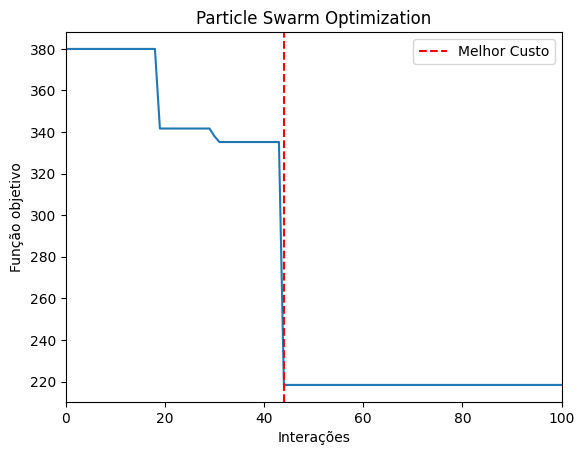


Cenário: quarto_cenario
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: R$ 218,37
Número de Iterações até o Melhor Custo: 45
Tempo de Convergência para a segunda etapa: 0.7342801094055176 segundos


In [255]:
# Plotar gráfico de densidade da otimização

plt.figure()
plt.plot(cost_history)



# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Localizando o índice da melhor interação
index_melhor_custo = cost_history.index(min(cost_history))

# Plotando a linha vertical
plt.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')


plt.xlabel('Interações')
plt.xlim(0, max_iterations)
plt.ylabel('Função objetivo')
# plt.ylim(0, 1500)
plt.title('Particle Swarm Optimization')
plt.legend()
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

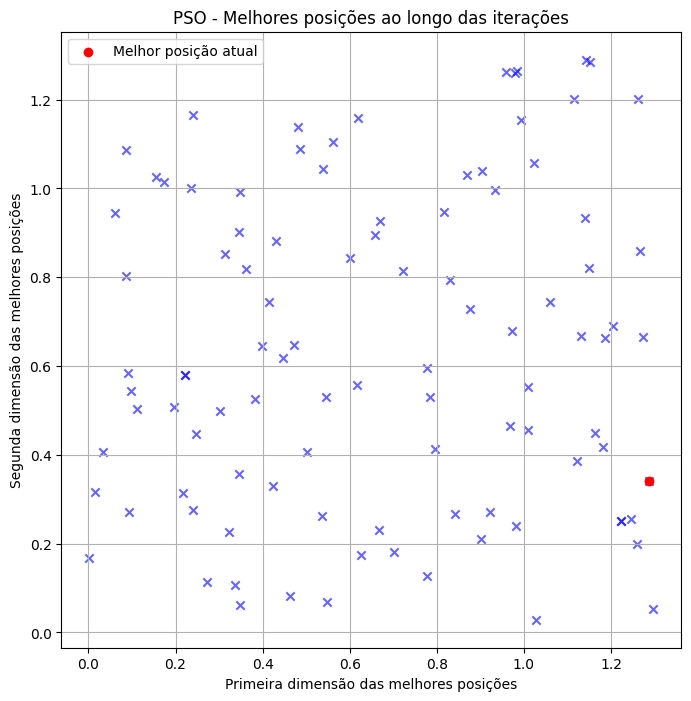

In [256]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [257]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [258]:
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_quarto_cenario/melhor_custo_pso_quarto_cenario.csv


In [259]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [260]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 211,89",1.272211,NaN
1,2,"R$ 214,67",1.161659,NaN


In [261]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       2 non-null      int64  
 1   Melhor_Custo                2 non-null      object 
 2   Convergencia_Segunda_Etapa  2 non-null      float64
 3   Ciclos_MP                   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 192.0+ bytes


In [262]:
resultado.describe()

,Index,Convergencia_Segunda_Etapa,Ciclos_MP
count,2.000000,2.000000,0.0
mean,1.500000,1.216935,NaN
std,0.707107,0.078172,NaN
min,1.000000,1.161659,NaN
25%,1.250000,1.189297,NaN
50%,1.500000,1.216935,NaN
75%,1.750000,1.244573,NaN
max,2.000000,1.272211,NaN


In [263]:
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [264]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [265]:
# # Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(convergencia):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [266]:
# Arrays de tempos e severidade
Tempos = [
[[303]],
[[336]],
[[272]],
[[62]],
[[517]],
[[364]],
[[332]],
[[360]],
[[395]],
[[303]],
]

severidade = [
    [[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [267]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,[303],[0.5]
1,[336],[0.5]
2,[272],[0.5]
3,[62],[0.5]
4,[517],[0.5]
5,[364],[0.5]
6,[332],[0.5]
7,[360],[0.5]
8,[395],[0.5]
9,[303],[0.5]


In [268]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [269]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,9,1
top,[303],[0.5]
freq,2,10
